In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install matplotlib

     |████████████████████████████████| 13.1MB 8.0MB/s eta 0:00:01    |███▌                            | 1.4MB 1.6MB/s eta 0:00:08     |█████████████████████           | 8.6MB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 92kB 10.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 10.7MB/s eta 0:00:01


In [1]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from kmcsim.buildtools import make_fcc, write_latt
import kmc_env
import kmcsim
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim
import os
import numpy as np
import collections
from kmc_env.envs.kmcsim_state_funcs import make_surface_proj,calc_roughness,get_state_reward,get_incremented_rates,gaussian
from kmc_env.envs.kmc_env import *
from matplotlib import pyplot as plt
import random
from collections import deque
import tensorflow as tf
import time
import sys
from copy import deepcopy

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Reshape, Flatten, Add, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
from IPython.display import clear_output

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from kmcsim.buildtools import make_fcc, write_latt
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size,gamma=0.5,epsilon=0.8,epsilon_min=0,epsilon_decay=0.992):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, activation='tanh', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
        model.add(MaxPool2D((2,2)))
        model.add(Conv2D(64, activation='tanh', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
        model.add(MaxPool2D((2,2)))
        model.add(Conv2D(32, activation='tanh', kernel_size = (3,3), strides = (1,1)))
        model.add(MaxPool2D((2,2)))
        model.add(Flatten())
        model.add(Dense(128, activation='tanh'))
        model.add(Dense(128, activation='tanh'))
        model.add(Dense(self.action_size*3, activation='linear'))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        #model.build()
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            action = [np.random.randint(0, 3) for i in range(self.action_size)]#, np.random.randint(0, 3), np.random.randint(0, 3)]
            decision=0

        else:
            action = [np.argmax(self.model.predict(state[None,:,:,None])[0][i*3:(i+1)*3]) for i in range(self.action_size)]
            #action = [np.argmax(self.model.predict(state[None,:,:,None])[0][i*3:(i+1)*3]),
            #          np.argmax(self.model.predict(state[None,:,:,None])[0][3:6]),
            #          np.argmax(self.model.predict(state[None,:,:,None])[0][6:])]
            print(action)
            decision=1
   
        return action,decision  # returns action

    def replay(self, batch_size):
        state, action, reward_new, next_state, done = self.memory[-1]
        ns_s=next_state[None,:,:,None]-next_state[None,:,:,None].mean()
        target = (reward_new + self.gamma *
                      np.amax(self.model.predict(ns_s)))
        s_s=state[None,:,:,None]-state[None,:,:,None].mean()
        target_f = self.model.predict(s_s)[0]
        target_f[action] = target
        self.model.fit(s_s, target_f.reshape(-1, self.action_size*3), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)




In [5]:
box = [16, 32, 4]
box_extension=32
target_roughness=0.98
EPISODES=150
wdir=r'../kmc_env/envs/data'

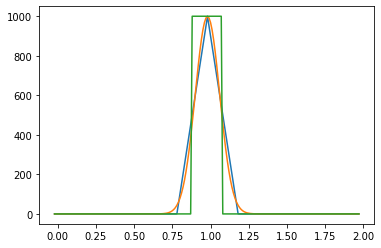

In [6]:
w=2

x=np.arange(-1,1,0.01)
y=1-np.abs(x*10*1/w)
y=y*1000
y[y<-1]=-1

y1=gaussian(x,sig=0.04*w,mu=0)*1000-1 

y2=np.ones_like(x)*1000
y2[x>0.05*w]=-1
y2[x<-0.05*w]=-1
plt.plot(x+target_roughness,y)
plt.plot(x+target_roughness,y1)
plt.plot(x+target_roughness,y2)
plt.show()

In [7]:
env = KmcEnv(box=box,box_extension=box_extension,target_roughness=target_roughness,
             reward_type='gaussian',reward_multiplier=1000,reward_tolerance=2,
             rates_spread=0.1,rates_adjustment=1,folder_with_params=wdir)
state,reward = env.reset()
state_size = env.state.shape
action_size = 3
agent = DQNAgent(state_size, action_size)

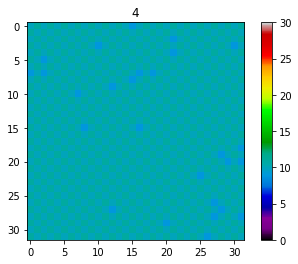

episode: 149/150, RMS: 0.5477, score: -0.9995, thickness: 10.45, e: 0.001936, decision: 1, done: 1


In [8]:
done = False
batch_size = 1
env._max_episode_steps = None
for e in range(EPISODES):
    state,reward = env.reset()
    done=env.end_flag
    count=0
    while not done:
        if done:
            print("episode: {}/{}, RMS: {}, score: {}, e: {:.2}"
                  .format(e, EPISODES, rms_val, reward, agent.epsilon))
            break
            
        action, decision = agent.act(state)
        next_state, reward, done = env.step(action, verbose=False)
        agent.remember(state, action, reward, next_state, done)
        agent.replay(batch_size)
        state = next_state
        rms_val = calc_roughness(state)
        thickness=np.mean(state)
        clear_output(wait=True) 
        plt.title(count)
        plt.imshow(state,vmin=0,vmax=30,cmap='nipy_spectral')
        plt.colorbar()
        plt.show()
        print("episode: {}/{}, RMS: {:.4}, score: {:.4}, thickness: {:.4}, e: {:.4}, decision: {}, done: {}"
                  .format(e, EPISODES, rms_val, reward, thickness, agent.epsilon, decision, done))
        count=count+1


In [ ]:
agent.model.load(r"C:\Users\ni1\Documents\RL\kmcenv\kmc-openai-env\supporting files\RL_DQN_0_98_adj_rates_m.h5")

In [ ]:
agent.model.load_weights(r"C:\Users\ni1\Documents\RL\kmcenv\kmc-openai-env\supporting files\RL_DQN_0_98_adj_rates.h5")

In [9]:
class RandomAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)

    def act(self, state):
        action = [np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(0, 3),
                 ]
        decision=0
        return action,decision 

In [22]:
env = KmcEnv(box=box,box_extension=box_extension,target_roughness=target_roughness,
              reward_type='gaussian',reward_multiplier=1000,reward_tolerance=2,
              rates_spread=0.1,rates_adjustment=1,folder_with_params=wdir)

env._max_episode_steps = None

state1,reward = env.reset()
env1=deepcopy(env)

rms_vals_rand=[]
thickness_vals_rand=[]

rms_vals_dqn=[]
thickness_vals_dqn=[]

random_agent=RandomAgent(state_size, action_size)
    

dqn_actions = []
start_temps = []
for i in range(50):
    print('Episode {} of 50'.format(i))
    state1,reward = env.reset()     
    env1=deepcopy(env)
    done=False
    state=np.copy(state1)
    start_temps.append(env.sim.temp)

    while not done:
        action, decision = agent.act(state)
        next_state, reward, done = env.step(action, verbose=False)
        state = next_state
        rms_val = calc_roughness(state)
        thickness=np.mean(state)
        rms_vals_dqn+=[rms_val]
        thickness_vals_dqn+=[thickness]
        dqn_actions.append(action)
    
    done=False
    state=np.copy(state1)
    while not done:
        action, decision = random_agent.act(state)
        next_state, reward, done = env1.step(action, verbose=False)
        state = next_state
        rms_val = calc_roughness(state)
        thickness=np.mean(state)
        rms_vals_rand+=[rms_val]
        thickness_vals_rand+=[thickness]'''

[0, 0, 2]
Existing rates: [0.2    0.3    0.278  0.215  0.2382]
New rates: [0.18000000000000002, 0.28, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 2]
Existing rates: [0.18   0.28   0.285  0.2325 0.2515]
New rates: [0.18000000000000002, 0.28, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 1]
Existing rates: [0.18   0.28   0.285  0.2325 0.2515]
New rates: [0.18000000000000002, 0.28, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.18  0.28  0.28  0.22  0.242]
New rates: [0.18000000000000002, 0.28, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.18  0.28  0.28  0.22  0.242]
New rates: [0.18000000000000002, 0.28, 0.28, 0.22, 0.242]
[0, 0, 2]
Existing rates: [0.3    0.2    0.294  0.255  0.2686]
New rates: [0.28, 0.18000000000000002, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 1]
Existing rates: [0.28   0.18   0.285  0.2325 0.2515]
New rates: [0.28, 0.18000000000000002, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.28  0.18  0.28  0.22  0.242]
New rates: [

[1, 1, 1]
Existing rates: [0.16   0.16   0.285  0.2325 0.2515]
New rates: [0.16000000000000003, 0.16000000000000003, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.16  0.16  0.28  0.22  0.242]
New rates: [0.16000000000000003, 0.16000000000000003, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.16  0.16  0.28  0.22  0.242]
New rates: [0.16000000000000003, 0.16000000000000003, 0.28, 0.22, 0.242]
[0, 0, 2]
Existing rates: [0.1     0.2     0.2843  0.23075 0.25017]
New rates: [0.08, 0.18000000000000002, 0.28500000000000003, 0.23249999999999998, 0.2515]
[0, 0, 2]
Existing rates: [0.08   0.18   0.285  0.2325 0.2515]
New rates: [0.06, 0.16000000000000003, 0.28500000000000003, 0.23249999999999998, 0.2515]
[2, 0, 2]
Existing rates: [0.06   0.16   0.285  0.2325 0.2515]
New rates: [0.08, 0.14000000000000004, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 1]
Existing rates: [0.08   0.14   0.285  0.2325 0.2515]
New rates: [0.08, 0.14000000000000004, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing r

[0, 0, 2]
Existing rates: [0.18   0.08   0.285  0.2325 0.2515]
New rates: [0.16000000000000003, 0.06, 0.28500000000000003, 0.23249999999999998, 0.2515]
[0, 0, 2]
Existing rates: [0.16   0.06   0.285  0.2325 0.2515]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 1]
Existing rates: [0.14   0.04   0.285  0.2325 0.2515]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.14  0.04  0.28  0.22  0.242]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28, 0.22, 0.242]
[0, 0, 2]
Existing rates: [0.1     0.1     0.2903  0.24575 0.26157]
New rates: [0.08, 0.08, 0.28500000000000003, 0.23249999999999998, 0.2515]
[0, 0, 2]
Existing rates: [0.08   0.08   0.285  0.2325 0.2515]
New rates: [0.06, 0.06, 0.28500000000000003, 0.23249999999999998, 0.2515]
[0, 0, 2]
Existing rates: [0.06   0.06   0.285  0.2325 0.2515]
New rates: [0.039999999999999994, 0.039999999999999994, 0.28500000000

[0, 0, 1]
Existing rates: [0.16   0.06   0.285  0.2325 0.2515]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28, 0.22, 0.242]
[1, 1, 2]
Existing rates: [0.14  0.04  0.28  0.22  0.242]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 1]
Existing rates: [0.14   0.04   0.285  0.2325 0.2515]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28, 0.22, 0.242]
[0, 0, 2]
Existing rates: [0.2   0.1   0.28  0.22  0.242]
New rates: [0.18000000000000002, 0.08, 0.28500000000000003, 0.23249999999999998, 0.2515]
[0, 0, 2]
Existing rates: [0.18   0.08   0.285  0.2325 0.2515]
New rates: [0.16000000000000003, 0.06, 0.28500000000000003, 0.23249999999999998, 0.2515]
[2, 0, 2]
Existing rates: [0.16   0.06   0.285  0.2325 0.2515]
New rates: [0.18000000000000002, 0.039999999999999994, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 2]
Existing rates: [0.18   0.04   0.285  0.2325 0.2515]
New rates: [0.18000000000000002, 

[0, 0, 2]
Existing rates: [0.18   0.08   0.285  0.2325 0.2515]
New rates: [0.16000000000000003, 0.06, 0.28500000000000003, 0.23249999999999998, 0.2515]
[0, 0, 2]
Existing rates: [0.16   0.06   0.285  0.2325 0.2515]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 1]
Existing rates: [0.14   0.04   0.285  0.2325 0.2515]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.14  0.04  0.28  0.22  0.242]
New rates: [0.14000000000000004, 0.039999999999999994, 0.28, 0.22, 0.242]
[0, 0, 2]
Existing rates: [0.2     0.3     0.2853  0.23325 0.25207]
New rates: [0.18000000000000002, 0.28, 0.28500000000000003, 0.23249999999999998, 0.2515]
[1, 1, 1]
Existing rates: [0.18   0.28   0.285  0.2325 0.2515]
New rates: [0.18000000000000002, 0.28, 0.28, 0.22, 0.242]
[1, 1, 1]
Existing rates: [0.18  0.28  0.28  0.22  0.242]
New rates: [0.18000000000000002, 0.28, 0.28, 0.22, 0.242]
[1, 1, 1]
Existin

In [37]:
temp_rates = [-50,0,50]
all_temp_profiles = []
for i in range(50):
    temp_profile =[]
    my_actions = dqn_actions[i*5:5*(i+1)]
    temp_actions = [mat[2] for mat in my_actions[:]]
    start_temp = start_temps[i]
    temp_profile.append(start_temp)
    for taction in temp_actions: 
        dt = temp_rates[taction]
        new_temp = temp_profile[-1] + dt
        temp_profile.append(new_temp)
        
    all_temp_profiles.append(temp_profile)
        

Text(0, 0.5, 'Temperature (K)')

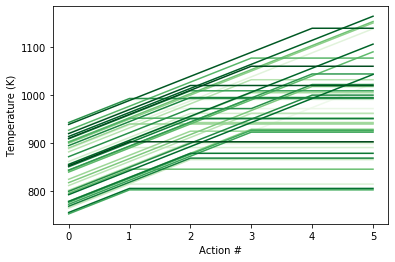

In [56]:
plt.figure()
reds = plt.cm.get_cmap('Greens', 50)
for ind in range(50):
    plt.plot(all_temp_profiles[ind], c = reds(ind))
plt.xlabel('Action #')
plt.ylabel('Temperature (K)')

In [31]:
len(start_temps)

50

In [ ]:
temp_profile = []
temp_profile.append(start_temps[0])

In [11]:
rms_vals_dqn=np.load('rms_vals_dqn.npy')
rms_vals_rand=np.load('rms_vals_rand.npy')
thickness_vals_dqn=np.load('thickness_vals_dqn.npy')
thickness_vals_rand=np.load('thickness_vals_rand.npy')

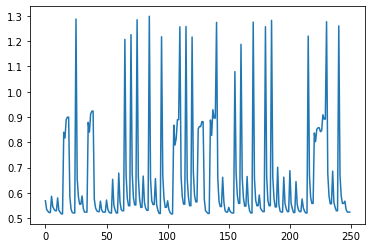

In [57]:
plt.figure()
plt.plot(rms_vals_dqn)

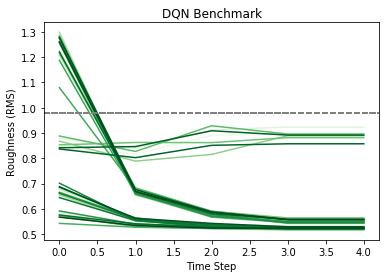

In [61]:
for i in range(50):
    plt.plot(np.arange(5),rms_vals_dqn[i*5:i*5+5],c=reds(i),alpha=1)
    plt.axhline(0.98,linestyle='--',c='0.5')
    plt.xlabel('Time Step')
    plt.ylabel('Roughness (RMS)')
    plt.title('DQN Benchmark')
plt.show()

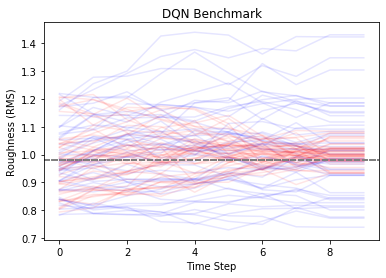

In [20]:
for i in range(50):
    plt.plot(np.arange(10),rms_vals_dqn[i*10:i*10+10],c='r',alpha=0.1)
    plt.plot(np.arange(10),rms_vals_rand[i*10:i*10+10],c='b',alpha=0.1)
    plt.axhline(0.98,linestyle='--',c='0.5')
    plt.xlabel('Time Step')
    plt.ylabel('Roughness (RMS)')
    plt.title('DQN Benchmark')
plt.show()



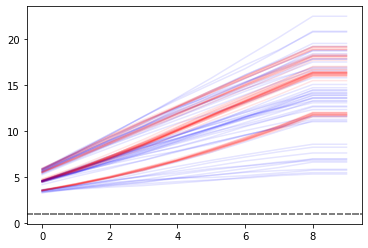

In [14]:
for i in range(50):
    plt.plot(np.arange(10),thickness_vals_dqn[i*10:i*10+10],c='r',alpha=0.1)
    plt.plot(np.arange(10),thickness_vals_rand[i*10:i*10+10],c='b',alpha=0.1)
    plt.axhline(0.98,linestyle='--',c='0.5')
plt.show()